In [26]:
#importing necessary libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [27]:
mat = loadmat('ex4data1') #load matlab files
X = mat['X']
y = mat['y']
print(X.shape)
print(y.shape)


(5000, 400)
(5000, 1)


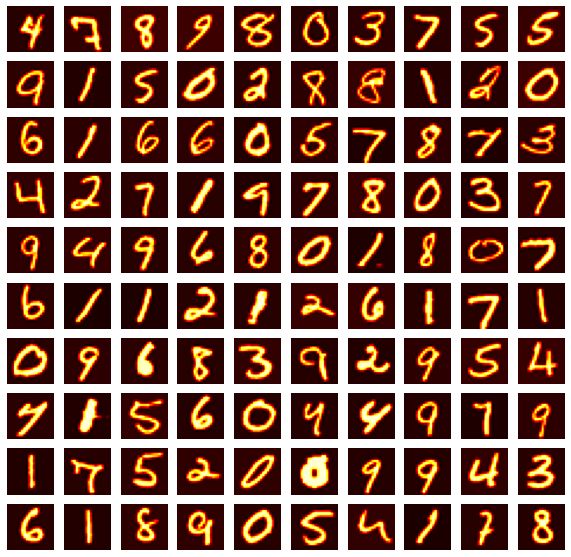

In [28]:
#visualizing our dataset
fig, axis = plt.subplots(10,10,figsize = (10,10))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order = 'F'), cmap = 'hot')
        axis[i,j].axis('off')

In [29]:
#using already trained parameters
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print(theta1.shape)
print(theta2.shape)

theta_vec = np.hstack((theta1.ravel(order = 'F'),theta2.ravel(order = 'F')))
input_layer_size = 400
hidden_layer_size = 25
num_labels =10
lmbda = 1

(25, 401)
(10, 26)


In [30]:
#defining the sigmoid function
def sigmoid(z):
   return 1 / (1 + np.exp(-z))

In [31]:
#defining Cost Function
def nnCostFunc(theta_vec,X,y,lmbda):
    theta1 = np.reshape(theta_vec[:(25 * 401)],(25,401),'F')
    theta2 = np.reshape(theta_vec[(25 * 401):],(10,26),'F')
    
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones,X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones,a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d,np.log(h))
    temp2 = np.multiply(1-y_d,np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2),axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2),axis = 1))
    return np.sum(temp3/(-m)) + (sum1 + sum2)*lmbda/(2*m)                   
    

In [32]:
nnCostFunc(theta_vec,X,y,lmbda)


0.38376985909092354

In [8]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z),1-sigmoid(z))

In [9]:
#randomly initializing parameters to train our own
def randomInitialize(L_in,L_out):
    epsilon = 0.12
    return np.random.rand(L_out,L_in+1)*2*epsilon - epsilon

initial_theta1 = randomInitialize(input_layer_size,hidden_layer_size)
initial_theta2 = randomInitialize(hidden_layer_size,num_labels)

nn_inital_params = np.hstack((initial_theta1.ravel(order = 'F'),initial_theta2.ravel(order = 'F')))
                             


In [10]:
#defining function for front and back propagation 
def nnGrad(nn_initial_params,X,y,lmbda):
    initial_theta1 = np.reshape(nn_initial_params[:(25 * 401)],(25,401),'F')
    initial_theta2 = np.reshape(nn_initial_params[(25 * 401):],(10,26),'F')
    
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones,X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = sigmoid(z2)
        a2 = np.hstack((ones,a2))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)
        
        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones,z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:]*lmbda/m 
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:]*lmbda/m
    
    return np.hstack((delta1.ravel(order = 'F'),delta2.ravel(order ='F')))

In [11]:
nn_backprop_Params = nnGrad(nn_inital_params, X, y, lmbda)

<ipython-input-10-f47cce24a0bd>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  d3 = a3 - y_d.iloc[i,:][np.newaxis,:]


In [ ]:
#function to check if the above grad function is working fine
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),myX,myy,mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print(f"Element: {x}. Numerical Gradient = {mygrad}. BackProp Gradient = {flattenedDs[x]}.")

In [37]:
checkGradient(nn_inital_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 1224. Numerical Gradient = 0.00015335309022646015. BackProp Gradient = 0.0001533531076866972.
Element: 9772. Numerical Gradient = -2.343184313247093e-05. BackProp Gradient = -2.343184566926638e-05.
Element: 2895. Numerical Gradient = -0.0017768317084332352. BackProp Gradient = -0.0017768317268633419.
Element: 4031. Numerical Gradient = -3.076694454762219e-06. BackProp Gradient = -3.076699157115516e-06.
Element: 9077. Numerical Gradient = -6.253202400330338e-06. BackProp Gradient = -6.253211261022559e-06.
Element: 1907. Numerical Gradient = -3.0715328058761315e-05. BackProp Gradient = -3.0715326813985555e-05.
Element: 8373. Numerical Gradient = -0.0002760417139313631. BackProp Gradient = -0.00027604169587195813.
Element: 476. Numerical Gradient = 1.952563000173768e-05. BackProp Gradient = 1.952563038843216e-05.
Element: 1974. Numerical Gradient = 0.00014638367851205203. BackProp Gradient = 0.00014638369314023085.
Element: 7245. Numerical Gradient = -0.002501064013671339. BackPr

In [33]:
#using an advanced optimizing function to find optimum parameter values
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_inital_params, fprime = nnGrad, \
                        args = (X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

<ipython-input-10-f47cce24a0bd>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  d3 = a3 - y_d.iloc[i,:][np.newaxis,:]


         Current function value: 0.437767
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


In [34]:
#function to get accuracy
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1

In [35]:
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred == y.flatten()) * 100

96.28